Assignment 6 - Text classification using Deep Learning
DESCRIPTION

Text classification using Deep Learning



Winter is... hopefully over.



In class this week, we've seen how deep learning models like CNNs can be used for text classification purposes. For your assignment this week, I want you to see how successfully you can use these kind of models to classify a specific kind of cultural data - scripts from the TV series Game of Thrones.



You can find the data here: https://www.kaggle.com/albenft/game-of-thrones-script-all-seasons



In particular, I want you to see how accurately you can model the relationship between each series and the lines spoken. That is to say - can you predict which series a line comes from? Or to phrase that another way, is dialogue a good predictor of series?



Start by making a baseline using a 'classical' ML solution such as CountVectorization + LogisticRegression and use this as a means of evaluating how well your model performs. Then you should try to come up with a solution which uses a DL model, such as the CNNs we went over in class.





Tips

Think carefully about the kind of preprocessing steps your text data may require and document these decisions.
Think just as carefully about the kind of parameters you use in you model. They all make a difference!
Some sentences are very short; some are longer. Think about how you should handle this.


General instructions

You should upload standalone .py script(s) which can be executed from the command line - one for the LogisticRegression model and one for the DL model.
You must include a requirements.txt file and a bash script to set up a virtual environment for the project You can use those on worker02 as a template
You can either upload the scripts here or push to GitHub and include a link - or both!
Your code should be clearly documented in a way that allows others to easily follow the structure of your script and to use them from the command line


Purpose

This assignment is designed to test that you have an understanding of:

how to build CNN models for text classification;
how to use pre-trained word embeddings for downstream tasks;
how to work with real-world, complex cultural text data.

In [2]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB


# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, 
                                     Embedding, 
                                     Flatten, 
                                     GlobalMaxPool1D, 
                                     Conv1D,
                                     Dropout,
                                     BatchNormalization,
                                     LSTM,
                                     MaxPooling1D
                                    )
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

# matplotlib
import matplotlib.pyplot as plt


/home/cds-au604148/cds-fork/cds-language/assignments/assignment-6/got_venv/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


__Functions__


In [3]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
data = pd.read_csv(os.path.join("..", "data", "Game_of_Thrones_Script.csv"))
df = data

data = data.groupby(["Season", "Episode", "Name"])
data = data["Sentence"].agg(lambda x: " ".join(x)).to_frame()

data = data.reset_index().rename(columns ={"Sentence": "Text"})



In [72]:
print(data.sample(10))
print(df.sample(10))

        Season     Episode             Name  \
1965  Season 6   Episode 1   alliser thorne   
1222  Season 4   Episode 1        grey worm   
436   Season 2  Episode 10           doreah   
311   Season 1   Episode 8       robb stark   
2263  Season 6   Episode 7           sandor   
370   Season 1   Episode 9  tywin lannister   
1313  Season 4   Episode 2   oberyn martell   
610   Season 2   Episode 5           dagmer   
973   Season 3   Episode 3              men   
43    Season 1  Episode 10          hot pie   

                                                   Text  
1965  You all know why you're here Jon Snow is dead ...  
1222           You are not a smart man, Daario Naharis.  
436   Khaleesi, please. He said you'd never leave Qa...  
311   Treason? Sansa wrote this? Joffrey puts my fat...  
2263  Just one. He was a woman. I'm used to it. Hate...  
370   The boy may lack experience and sense, but he ...  
1313  Hello. Not you. Your Grace. Lord Tywin. I don'...  
610   Come on, I'l

In [13]:
# train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(data.Text,
                                                    data["Season"], 
                                                    test_size=0.3, 
                                                    random_state=42)

In [88]:
y_test

1968    Season 6
124     Season 1
1127    Season 3
1615    Season 5
1359    Season 4
          ...   
1684    Season 5
742     Season 2
1357    Season 4
1419    Season 4
230     Season 1
Name: Season, Length: 799, dtype: object

In [42]:
vectorizer = TfidfVectorizer(ngram_range=(1,2) )

# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train)
#... then we do it for our test data
X_test_feats = vectorizer.transform(X_test)
# We can also create a list of the feature names. 
feature_names = vectorizer.get_feature_names()

In [61]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge', penalty='l2'
                          ).fit(X_train_feats, y_train)
y_pred = classifier.predict(X_test_feats)
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

ValueError: Found input variables with inconsistent numbers of samples: [2129, 1863]

In [45]:
classifier = LogisticRegression().fit(X_train_feats, y_train)
y_pred = classifier.predict(X_test_feats)
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

    Season 1       0.37      0.46      0.41        72
    Season 2       0.32      0.52      0.40        88
    Season 3       0.24      0.33      0.28        84
    Season 4       0.37      0.18      0.24        78
    Season 5       0.29      0.32      0.30        75
    Season 6       0.40      0.28      0.33        76
    Season 7       1.00      0.28      0.43        36
    Season 8       0.50      0.04      0.08        24

    accuracy                           0.33       533
   macro avg       0.44      0.30      0.31       533
weighted avg       0.38      0.33      0.32       533



## SGDClassifier

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
random_state = 42
pipe = Pipeline(steps=[
     ('tfidf', TfidfVectorizer()),
     ('clf', SGDClassifier(random_state = random_state))
 ])

In [64]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

## specifying 
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
    'tfidf__max_df': [1.0, 0.95,0.9,0.85,0.8],
    'tfidf__min_df': [0.0, 0.05],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0], # learning rate
    'clf__penalty': ['l2'],  
}

search = GridSearchCV(pipe, parameters, verbose = 2,n_jobs = 12, refit = True)
gs_clf = search.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [65]:
gs_clf.best_score_

0.3671466459108075

In [66]:
gs_clf.best_params_

{'clf__alpha': 0.001,
 'clf__penalty': 'l2',
 'tfidf__max_df': 1.0,
 'tfidf__min_df': 0.0,
 'tfidf__ngram_range': (1, 2)}

In [67]:
y_pred = gs_clf.predict(X_test)

In [68]:

classifier_metrics = metrics.classification_report(y_test, y_pred)


In [69]:
print(classifier_metrics)

              precision    recall  f1-score   support

    Season 1       0.36      0.48      0.41       114
    Season 2       0.36      0.40      0.38       131
    Season 3       0.34      0.30      0.32       128
    Season 4       0.30      0.22      0.25       111
    Season 5       0.35      0.37      0.36       114
    Season 6       0.37      0.38      0.38       105
    Season 7       0.65      0.61      0.63        61
    Season 8       0.33      0.17      0.23        35

    accuracy                           0.37       799
   macro avg       0.38      0.37      0.37       799
weighted avg       0.37      0.37      0.37       799



## Shallow network with tfidf

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [81]:

# train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(data.Text,
                                                    data["Season"], 
                                                    test_size=0.1, 
                                                    random_state=42)
# integers to one-hot vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names for CIFAR-10 dataset
labelNames = df.Season.values

## CNN based on Glove

In [184]:
tf.keras.backend.clear_session()

# initialize tokenizer
tokenizer = Tokenizer()

# fit to training data

tokenizer.fit_on_texts(X_train)

# tokenized training and test data
X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

# overall vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(vocab_size)
# inspect
print(X_train[2])
print(X_train_toks[2])

9676
Is he dead yet? You got bigger. I rode all day. Didn't want to leave you alone with the Lannisters. Why aren't you at the feast? Well, you're always welcome on the wall. No bastard was ever refused a seat there. Jon… The Wall isn't going anywhere. You don't understand what you'd be giving up. We have no families. None of us will ever father sons. You might, if you knew what it meant. … I'd better get inside. Rescue your father from his guests. We'll talk later. You at a feast -- It's like a bear in a trap. Of course I did. Just a lad. But he was tough, Ned. A true Ranger. The two he was with are still missing. Maybe. Direwolves south of the wall. Talk of the Walkers. My brother might be the next Hand to the king. Winter is coming. Robb boy. How are ye?
[2, 27, 19, 769, 51, 113, 22, 4, 278, 2, 2857, 15, 13, 20, 4, 249, 34, 2, 463, 14, 1, 1308, 7, 8, 144, 6, 15, 13, 72, 18, 17, 3, 230, 40, 1, 801, 42, 770, 9, 69, 2031, 28, 403]


In [228]:


# pad training data to maxlen
X_train_pad = pad_sequences(X_train_toks, 
                            padding='post' # sequences can be padded "pre" or "post"
                            )
# pad testing data to maxlen
X_test_pad = pad_sequences(X_test_toks, 
                           padding='post',
                           maxlen=len(X_train_pad[0]))

246     Well, why shouldn't I? We're in the south. My ...
2119    My mother's still living at White Harbor Could...
289     You will not support us then? Do I understand ...
2323    When people ask you what happened here, tell t...
568     What kind of fire melts stone? There's dragons...
                              ...                        
1638    I can see I have my work cut out for me.You tw...
1095    Wa- Please. I'll tell you everything, please. ...
1130    Here. Let me. It will take time. How is the pa...
1294    She's the whore I told you about. The dark-hai...
860     How are you keeping? It was just a bit of bloo...
Name: Text, Length: 2395, dtype: object

__NN TFIDF__

In [77]:
maxlen =2
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = maxlen)

# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train)
X_test_feats = vectorizer.transform(X_test).toarray()

In [78]:
vectorizer.get_feature_names()

['000',
 '10',
 '100',
 '20',
 'able',
 'able to',
 'about',
 'about it',
 'about that',
 'about the',
 'about you',
 'about your',
 'across',
 'across the',
 'aegon',
 'afraid',
 'after',
 'again',
 'against',
 'against the',
 'age',
 'ago',
 'ah',
 'alive',
 'all',
 'all my',
 'all of',
 'all right',
 'all that',
 'all the',
 'all those',
 'all your',
 'allies',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'always been',
 'am',
 'am the',
 'an',
 'an army',
 'and',
 'and all',
 'and don',
 'and have',
 'and he',
 'and her',
 'and his',
 'and how',
 'and if',
 'and it',
 'and ll',
 'and my',
 'and no',
 'and now',
 'and she',
 'and take',
 'and that',
 'and the',
 'and then',
 'and there',
 'and they',
 'and we',
 'and what',
 'and when',
 'and will',
 'and you',
 'and your',
 'angry',
 'another',
 'answer',
 'any',
 'any of',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'are my',
 'are no',
 'are not',
 'are the',
 'are they',
 'ar

In [111]:
maxlen= 15000
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features =maxlen)

# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train).toarray()
#... then we do it for our test data
X_test_feats = vectorizer.transform(X_test).toarray()
# We can also create a list of the feature names. 
feature_names = vectorizer.get_feature_names()



l2 = L2(0.00001)

# New model
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2,input_shape=(maxlen,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy',
              optimizer= SGD(lr=  .01),
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                960064    
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 520       
Total params: 960,840
Trainable params: 960,712
Non-trainable params: 128
_________________________________________________________________


Training Accuracy: 0.9791
Testing Accuracy:  0.2996


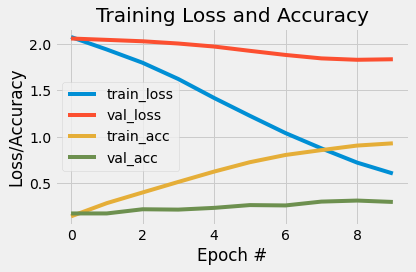

In [112]:
epochs = 10
history = model.fit(X_train_feats, y_train,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(X_test_feats, y_test))

# evaluate 
loss, accuracy = model.evaluate(X_train_feats, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_feats, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = epochs)

In [181]:
y_train

1784    Season 5
891     Season 3
1338    Season 4
2233    Season 6
1494    Season 4
          ...   
1638    Season 5
1095    Season 3
1130    Season 3
1294    Season 4
860     Season 3
Name: Season, Length: 1863, dtype: object

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(os.path.join(f'../glove/glove.6B.{embedding_dim}d.txt'),
                                           tokenizer.word_index, 
                                           embedding_dim)

l2 = L2(0.0001)

maxlen = len(X_train_pad[0])
# New model
model = Sequential()

# Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                    embedding_dim,               # embedding input layer size
                    weights=[embedding_matrix],  # pretrained embeddings
                    input_length=maxlen,         # maxlen of padded doc
                    trainable= True))             # trainable embeddings

model.add(Conv1D(128, 5, 
                activation='relu',
                kernel_regularizer=l2))          # L2 regularization 
model.add(BatchNormalization())
model.add(GlobalMaxPool1D())

model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(lr = 0.0001),
              metrics=['accuracy'])

# print summary
model.summary()

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(os.path.join(f'../glove/glove.6B.{embedding_dim}d.txt'),
                                           tokenizer.word_index, 
                                           embedding_dim)

l2 = L2(0.0001)

maxlen = len(X_train_pad[0])
# New model
model = Sequential()

# Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                    embedding_dim,               # embedding input layer size
                    weights=[embedding_matrix],  # pretrained embeddings
                    input_length=maxlen,         # maxlen of padded doc
                    trainable= True))             # trainable embeddings

model.add(Conv1D(16, 3, 
                activation='relu',
                kernel_regularizer=l2))          # L2 regularization 
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(32,dropout=0.20,recurrent_dropout=0.20))

model.add(Dense(8, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy'])

# print summary
#model.summary()